In [42]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import confusion_matrix

from load_data import load_problem

PICKLE_PATH = '../data/lasso_regression/lasso_data.pickle'

In [2]:
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(PICKLE_PATH)
X_train = featurize(x_train)
X_val = featurize(x_val)

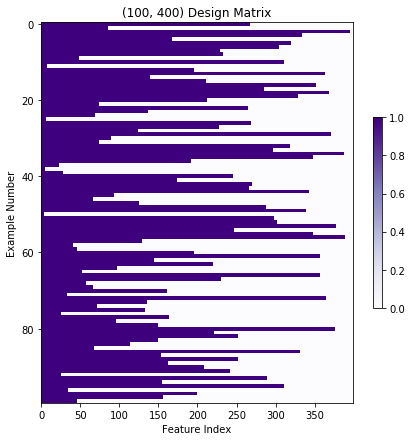

In [3]:
fig, ax = plt.subplots(figsize = (7,7))
ax.set_title("({0}, {1}) Design Matrix".format(X_train.shape[0], X_train.shape[1]))
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
temp = ax.imshow(X_train, cmap=plt.cm.Purples, aspect="auto")
plt.colorbar(temp, shrink=0.5);

## Ridge Regression

### Ridge Regression - Question 1

In [4]:
class RidgeRegression(BaseEstimator, RegressorMixin):
	""" ridge regression"""

	def __init__(self, l2reg=1):
		if l2reg < 0:
			raise ValueError('Regularization penalty should be at least 0.')
		self.l2reg = l2reg

	def fit(self, X, y=None):
		n, num_ftrs = X.shape
		# convert y to 1-dim array, in case we're given a column vector
		y = y.reshape(-1)
		def ridge_obj(w):
			predictions = np.dot(X,w)
			residual = y - predictions
			empirical_risk = np.sum(residual**2) / n
			l2_norm_squared = np.sum(w**2)
			objective = empirical_risk + self.l2reg * l2_norm_squared
			return objective
		self.ridge_obj_ = ridge_obj

		w_0 = np.zeros(num_ftrs)
		self.w_ = minimize(ridge_obj, w_0).x
		return self

	def predict(self, X, y=None):
		try:
			getattr(self, "w_")
		except AttributeError:
			raise RuntimeError("You must train classifer before predicting data!")
		return np.dot(X, self.w_)

	def score(self, X, y):
		# Average square error
		try:
			getattr(self, "w_")
		except AttributeError:
			raise RuntimeError("You must train classifer before predicting data!")
		residuals = self.predict(X) - y
		return np.dot(residuals, residuals)/len(y)

In [5]:
def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):

	# Fit with sklearn -- need to multiply l2_reg by sample size, since their
	# objective function has the total square loss, rather than average square
	# loss.
	n = X_train.shape[0]
	sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
	sklearn_ridge.fit(X_train, y_train)
	sklearn_ridge_coefs = sklearn_ridge.coef_

	# Now run our ridge regression and compare the coefficients to sklearn's
	ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
	ridge_regression_estimator.fit(X_train, y_train)
	our_coefs = ridge_regression_estimator.w_

	print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

In [6]:
compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1.5)

Hoping this is very close to 0:4.6884282980897267e-11


In [7]:
default_params = np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3))))

def do_grid_search_ridge(X_train, y_train, X_val, y_val, params = default_params):

	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	param_grid = [{'l2reg':params}]

	ridge_regression_estimator = RidgeRegression()
	grid = GridSearchCV(ridge_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_l2reg"])
	return grid, df_toshow

In [8]:
grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)

In [9]:
results

,param_l2reg,mean_test_score,mean_train_score
0,0.000001,0.172579,0.006752
1,0.000010,0.172464,0.006752
2,0.000100,0.171345,0.006774
3,0.001000,0.162705,0.008285
4,0.010000,0.141887,0.032767
5,0.100000,0.144566,0.094953
6,1.000000,0.171068,0.197694
7,1.300000,0.179521,0.216591
8,1.600000,0.187993,0.233450
9,1.900000,0.196361,0.248803


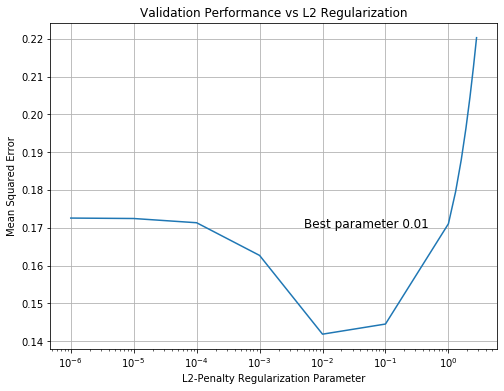

In [10]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.text(0.005,0.17,"Best parameter {0}".format(grid.best_params_['l2reg']), fontsize = 12);

### Ridge Regression - Question 2

In [11]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

pred_fns.append({"name": "Target Function", "coefs": coefs_true, "preds": target_fn(x)})

l2regs = [0, grid.best_params_['l2reg'], 1]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

In [12]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):

	fig, ax = plt.subplots(figsize = (12,8))
	ax.set_xlabel('Input Space: [0,1)')
	ax.set_ylabel('Action/Outcome Space')
	ax.set_title("Prediction Functions")
	plt.scatter(x_train, y_train, color="k", label='Training data')
	for i in range(len(pred_fns)):
		ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
	legend = ax.legend(loc=legend_loc, shadow=True)
	return fig

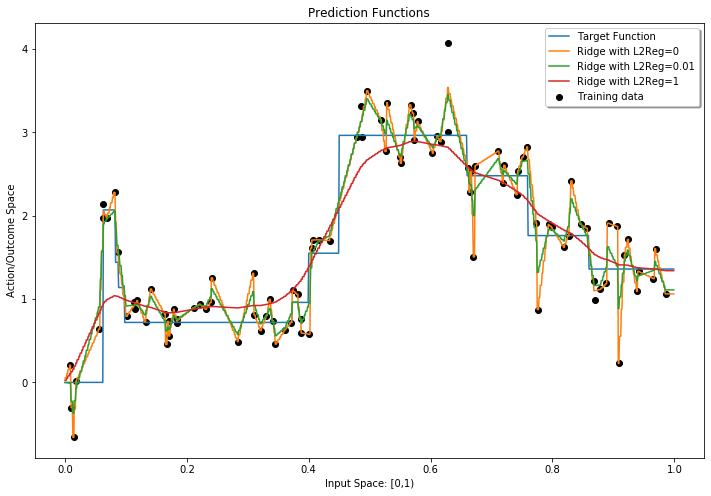

In [13]:
plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best");

In [14]:
def compare_parameter_vectors(pred_fns):

	fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (20,20))
	num_ftrs = len(pred_fns[0]["coefs"])
	for i in range(len(pred_fns)):
		title = pred_fns[i]["name"]
		coef_vals = pred_fns[i]["coefs"]
		axs[i].bar(range(num_ftrs), coef_vals, color = "tab:purple")
		axs[i].set_xlabel('Feature Index')
		axs[i].set_ylabel('Parameter Value')
		axs[i].set_title(title)

	fig.subplots_adjust(hspace=0.4)
	return fig

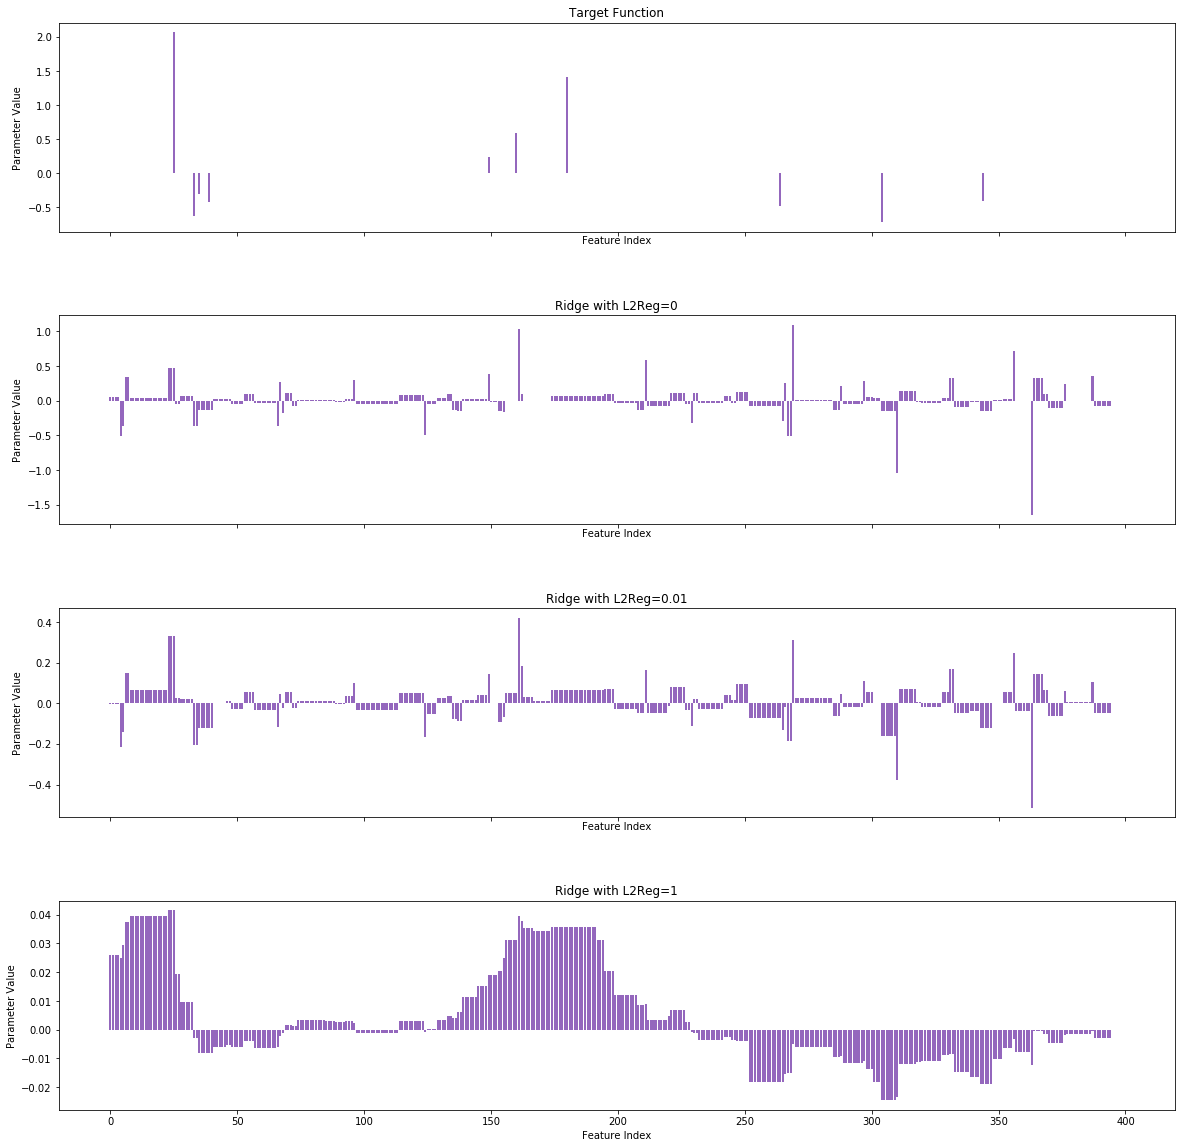

In [15]:
compare_parameter_vectors(pred_fns);

In ridge regression, we observe that by reducing the regularization parameter, we are introducing more sparsity in the weights. <br>
The co-efficients are more dense for $\lambda = 1$ and sparse for $\lambda = 0.01$. <br>
This is because the weight distribution of the paramters is more agressive in the case where $\lambda$ is small. <br>
From the scale of the co-efficients, we see that the weight is concentrated in only a few co-efficients for small $\lambda$, <br>
however for a large $\lambda$ this is distributed more evenly amongst the co-efficients.<br>

### Ridge Regression - Question 3

In [16]:
def plot_confusion_matrix(cm, title, classes):      
	 plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
	 plt.title(title)
	 plt.colorbar()
	 tick_marks = np.arange(len(classes))
	 plt.xticks(tick_marks, classes, rotation=45)
	 plt.yticks(tick_marks, classes)

	 thresh = cm.max() / 2.
	 for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):     
		 plt.text(j, i, format(cm[i, j], 'd'),      
				  horizontalalignment="center",     
				  color="white" if cm[i, j] > thresh else "black")      

	 plt.tight_layout()        
	 plt.ylabel('True label')       
	 plt.xlabel('Predicted label')

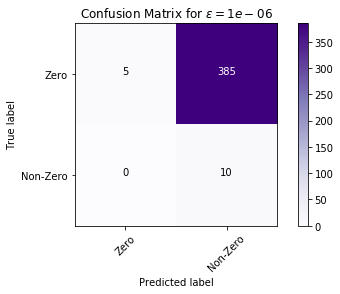

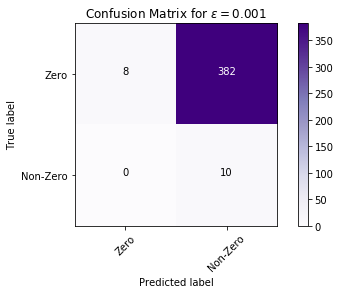

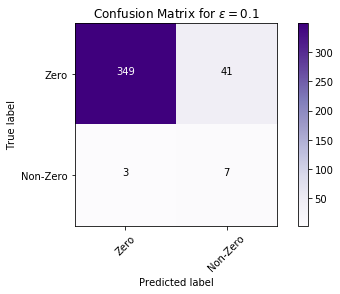

In [17]:
coefs_true_1 = pred_fns[2]['coefs']
bin_coefs_true = np.copy(coefs_true)
bin_coefs_true[bin_coefs_true != 0] = 1
eps_list = np.array([10**-6, 10**-3, 10**-1])
for eps in eps_list:
    bin_coefs_estimated = np.copy(coefs_true_1)
    bin_coefs_estimated[np.absolute(bin_coefs_estimated) < eps] = 0
    bin_coefs_estimated[np.absolute(bin_coefs_estimated) >= eps] = 1
    cnf_matrix = confusion_matrix(bin_coefs_true, bin_coefs_estimated)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])

## Lasso Regression

### Lasso Regression - Question 1

$$
a_{j}=2 X_{j}^{T} X_{j} \\
c_{j}=2X_{j}^{\top}\left(y-X w+w_{j} X_{j}\right)
$$

### Lasso Regression - Question 2

In [21]:
def soft_threshold(a, delta):
    return np.sign(a) * (np.absolute(a) - delta) if (np.absolute(a) - delta) > 0 else 0

def compute_sum_sqr_loss(X, y, w):
    return np.linalg.norm(np.dot(X, w) - y) ** 2

def compute_lasso_objective(X, y, w, l1_reg=0):
    return compute_sum_sqr_loss(X, y, w) + l1_reg * np.linalg.norm(w, ord = 1)

def get_ridge_solution(X, y, l2_reg):
    D = X.shape[1]
    return np.linalg.multi_dot([
            np.linalg.inv(
                np.dot(X.transpose(), X) + l2_reg * np.eye(D)
            ),
            X.transpose(),
            y
    ]
    )

In [31]:
def shooting_algorithm(X, y, w0=None, l1_reg = 1., max_num_epochs = 1000, min_obj_decrease=1e-8, random=False):
    if w0 is None:
        w = np.zeros(X.shape[1])
    else:
        w = np.copy(w0)
    d = X.shape[1]
    epoch = 0
    obj_val = compute_lasso_objective(X, y, w, l1_reg)
    obj_decrease = min_obj_decrease + 1.
    while (obj_decrease>min_obj_decrease) and (epoch<max_num_epochs):
        obj_old = obj_val
        # Cyclic coordinates descent
        coordinates = range(d)
        # Randomized coordinates descent
        if random:
            coordinates = np.random.permutation(d)
        for j in coordinates:
            X_j = X[:, j]
            a_j = 2 * np.dot(X_j.transpose(), X_j)
            c_j = 2 * np.dot(
                X_j.transpose(),
                y - np.dot(X, w) + w[j] * X_j
            )
            w[j] = soft_threshold(c_j / a_j, l1_reg / a_j) if a_j != 0 else 0

        obj_val = compute_lasso_objective(X, y, w, l1_reg)
        obj_decrease = obj_old - obj_val
        epoch += 1
    print("Ran for "+str(epoch)+" epochs. " + 'Lowest loss: ' + str(obj_val))
    return w, epoch

In [24]:
LAMBDA_BEST = 0.001

lambda_list = [10**-3, 10**-2, 10**-1, 10**-0.5, 10**-0.2, 1, 1.2, 1.5]
random = [True, False]
ridge_init = [True, False]

for lambda_reg in lambda_list:
    for r in random:
        for ri in ridge_init:
            w0 = get_ridge_solution(X_train, y_train, lambda_reg) if ri else None
            print('lambdarandom = {}, ridge_init = {}'.format(r, ri))
            w, num_epochs = shooting_algorithm(
                X_train,
                y_train,
                w0 = w0,
                l1_reg = LAMBDA_BEST,
                max_num_epochs = 1000,
                min_obj_decrease=1e-8,
                random=r
            )

            print('val loss = ' + str(compute_sum_sqr_loss(X_val, y_val, w)))

random = True, ridge_init = True
Ran for 143 epochs. Lowest loss: 0.712382152027932
val loss = 155.18428295079778
random = True, ridge_init = False
Ran for 1000 epochs. Lowest loss: 0.7216153644433857
val loss = 178.5937400192355
random = False, ridge_init = True
Ran for 231 epochs. Lowest loss: 0.7123822291806332
val loss = 155.2236212479017
random = False, ridge_init = False
Ran for 1000 epochs. Lowest loss: 0.7123894748083615
val loss = 205.00096022050406


The training loss is more or less the same across all configs. <br>
Hence we should look at validation loss. <br>
After 1000 epochs, the lowest validation loss (~155) is achieved for the following configs:<br>
1. random = True and ridge solution initization = True <br>
2. random = False and ridge solution initization = True <br>
Therefore, ridge solution initization makes a big difference to performance on the validation loss.

In [29]:
def get_top_dict_values(dict_, k, order = 0):
    """
    Sorts a dict and returns the top k elems as a list of tuples (ordered by values)
    order = 0 for ascending, order = 1 for descending
    """
    
    # map the order from {0, 1} to {-1, 1}
    order = order * 2 - 1
    
    d = {k:v for k, v in sorted(dict_.items(), key = lambda item : -order*item[1])}
    ret_list = []
    for x in list(d)[0:(k + 1)]:
        ret_list.append((x, d[x]))
    
    return ret_list

def print_top_dict_values(dict_, k, order = 0):
    """
    Prints the top k elems of the dictionary (ordered by values)
    order = 0 for ascending, order = 1 for descending
    """
    
    for x in get_top_dict_values(dict_, k, order):
        print("{}\t{}".format(x[1], x[0]))

In [54]:
random = [True, False]
ridge_init = [True, False]
config_val_loss_map = {}
lambda_list = [10**-3, 10**-2, 10**-1, 10**-0.5, 10**-0.2, 1, 1.2, 1.5]
for lambda_reg in lambda_list:
    for min_obj_decrease in [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]:
        for r in random:
            for ri in ridge_init:
                w0 = get_ridge_solution(X_train, y_train, lambda_reg) if ri else None
                # print('random = {}, ridge_init = {}, error_diff = {}'.format(r, ri, min_obj_decrease))
                w, num_epochs = shooting_algorithm(
                    X_train,
                    y_train,
                    w0 = w0,
                    l1_reg = lambda_reg,
                    max_num_epochs = 1000,
                    min_obj_decrease=min_obj_decrease,
                    random=r
                )

                val_loss = compute_sum_sqr_loss(X_val, y_val, w)
                config_val_loss_map[(lambda_reg, min_obj_decrease, r, ri, num_epochs)] = val_loss

                # print('val loss = ' + str(val_loss))

Ran for 1 epochs. Lowest loss: 0.7124142540408099
Ran for 513 epochs. Lowest loss: 0.7337735951580893
Ran for 1 epochs. Lowest loss: 0.7124162724659511
Ran for 476 epochs. Lowest loss: 0.71727206982348
Ran for 1 epochs. Lowest loss: 0.7124138730728969
Ran for 621 epochs. Lowest loss: 0.7199936950853307
Ran for 1 epochs. Lowest loss: 0.7124162724659511
Ran for 601 epochs. Lowest loss: 0.7131773897890529
Ran for 10 epochs. Lowest loss: 0.7123995076021755
Ran for 1000 epochs. Lowest loss: 0.7186873568602308
Ran for 6 epochs. Lowest loss: 0.7124100450633201
Ran for 790 epochs. Lowest loss: 0.7124635675825028
Ran for 59 epochs. Lowest loss: 0.7123849802919313
Ran for 1000 epochs. Lowest loss: 0.7241561340119952
Ran for 84 epochs. Lowest loss: 0.7123875246780428
Ran for 988 epochs. Lowest loss: 0.7123905843675472
Ran for 140 epochs. Lowest loss: 0.7123821817912988
Ran for 1000 epochs. Lowest loss: 0.7246747676245555
Ran for 231 epochs. Lowest loss: 0.7123822291806332
Ran for 1000 epochs. Low

In [55]:
print('validation loss\t\t(lambda, min_decrease, random, ridge_init, epochs)')
print_top_dict_values(config_val_loss_map, len(config_val_loss_map))

validation loss		(lambda, min_decrease, random, ridge_init, epochs)
105.6544428113922	(1.2, 1e-07, True, False, 519)
107.80096629510328	(1.5, 1e-06, True, False, 460)
109.4380884064041	(1.2, 1e-06, True, False, 412)
110.84253550724583	(1, 1e-07, True, False, 550)
111.18129085727655	(1.2, 1e-08, True, False, 677)
111.42244859212475	(1, 1e-08, True, False, 719)
111.9052058203455	(1.5, 1e-05, True, True, 251)
111.92419583049022	(1.5, 1e-07, True, True, 513)
112.10960151518039	(1, 1e-06, True, False, 460)
112.32543298636877	(0.6309573444801932, 0.0001, True, False, 276)
112.45409120665991	(1.5, 1e-08, True, False, 657)
113.02543807882729	(1.2, 1e-07, True, True, 512)
113.06266151769925	(1.2, 1e-08, True, True, 664)
113.14453918399005	(1, 1e-06, True, True, 388)
113.14679284539946	(1.2, 1e-05, True, True, 250)
113.19543653136368	(1.5, 1e-06, True, True, 379)
113.3575789771974	(1.2, 1e-08, False, True, 722)
113.36234871321611	(1.2, 1e-07, False, True, 578)
113.38797716495547	(1.2, 1e-06, Fal

As seen above, the best validation loss (105.6544) is achieved for the config:<br>
lambda = 1.2 <br>
min_decrease = 1e-07 <br>
randomized co-ordinates = True <br>
ridge solution init = False <br><br>
This is good model from the convergence perspective too since it converges within <br>
just 519 epochs.

### Lasso Regression - Question 3

In [56]:
class LassoRegression(BaseEstimator, RegressorMixin):
    """ Lasso regression"""
    def __init__(self, l1_reg=1.0, randomized=False):
        if l1_reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l1_reg = l1_reg
        self.randomized = randomized


    def fit(self, X, y, max_epochs = 1000, coef_init=None):
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        if coef_init is None:
            coef_init = get_ridge_solution(X,y, self.l1_reg)
        
        self.lasso_obj_ = compute_lasso_objective
        self.w_, epochs = shooting_algorithm(
            X,
            y,
            w0 = coef_init,
            l1_reg = self.l1_reg,
            max_num_epochs = max_epochs,
            min_obj_decrease=1e-7,
            random=self.randomized
        )
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return np.dot(X, self.w_)

    def score(self, X, y):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return compute_sum_sqr_loss(X, y, self.w_)/len(y)

In [57]:
def compare_our_lasso_with_sklearn(X_train, y_train, l1_reg=1):
    
    # Fit with sklearn -- need to divide l1_reg by 2*sample size, since they
    # use a slightly different objective function.
    n = X_train.shape[0]
    sklearn_lasso = Lasso(alpha=l1_reg/(2*n), fit_intercept=False, normalize=False)
    sklearn_lasso.fit(X_train, y_train)
    sklearn_lasso_coefs = sklearn_lasso.coef_
    sklearn_lasso_preds = sklearn_lasso.predict(X_train)

    # Now run our lasso regression and compare the coefficients to sklearn's
    lasso_regression_estimator = LassoRegression(l1_reg=l1_reg)
    lasso_regression_estimator.fit(X_train, y_train)
    our_coefs = lasso_regression_estimator.w_
    lasso_regression_preds = lasso_regression_estimator.predict(X_train)

    # Let's compare differences in predictions
    print("Hoping this is very close to 0 (predictions): {}".format( np.mean((sklearn_lasso_preds - lasso_regression_preds)**2)))
    # Let's compare differences parameter values
    print("Hoping this is very close to 0: {}".format(np.sum((our_coefs - sklearn_lasso_coefs)**2)))

In [58]:
compare_our_lasso_with_sklearn(X_train, y_train, l1_reg=1.5)

Ran for 563 epochs. Lowest loss: 19.50801497081069
Hoping this is very close to 0 (predictions): 2.54037197132137e-07
Hoping this is very close to 0: 3.0891165860079597


In [59]:
default_params = np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3))))

def do_grid_search_lasso(X_train, y_train, X_val, y_val, params = default_params):
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val)
    
    param_grid = [{'l1_reg':params}]
    lasso_regression_estimator = LassoRegression(
        randomized = True
    )
    grid = GridSearchCV(lasso_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
    grid.fit(X_train_val, y_train_val)
    
    df = pd.DataFrame(grid.cv_results_)
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l1_reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l1_reg"])
    
    return grid, df_toshow

In [60]:
grid, results = do_grid_search_lasso(X_train, y_train, X_val, y_val)

Ran for 1 epochs. Lowest loss: 0.6752223426175992
Ran for 1 epochs. Lowest loss: 0.6755576053485076
Ran for 1 epochs. Lowest loss: 0.6789100322506292
Ran for 57 epochs. Lowest loss: 0.7123852387595591
Ran for 296 epochs. Lowest loss: 1.0422533283754398
Ran for 698 epochs. Lowest loss: 3.9049842246089446
Ran for 519 epochs. Lowest loss: 16.197743151819466
Ran for 521 epochs. Lowest loss: 18.208743755821914
Ran for 544 epochs. Lowest loss: 20.146337481238387
Ran for 522 epochs. Lowest loss: 22.016052566318557
Ran for 529 epochs. Lowest loss: 23.818260784611383
Ran for 522 epochs. Lowest loss: 25.5593175270783
Ran for 525 epochs. Lowest loss: 27.24293964814968
Ran for 1000 epochs. Lowest loss: 96.05527770957859


In [61]:
results

,param_l1_reg,mean_test_score,mean_train_score
0,0.000001,0.172590,0.006752
1,0.000010,0.172589,0.006752
2,0.000100,0.172576,0.006752
3,0.001000,0.172432,0.006752
4,0.010000,0.170984,0.006804
5,0.100000,0.158606,0.011134
6,1.000000,0.125445,0.091951
7,1.300000,0.124813,0.096655
8,1.600000,0.124133,0.099937
9,1.900000,0.127846,0.103895


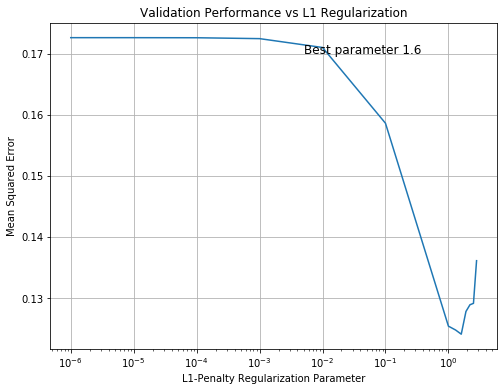

In [62]:
# Plot validation performance vs regularization parameter

fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.semilogx(results["param_l1_reg"], results["mean_test_score"])

ax.text(0.005,0.17,"Best parameter {0}".format(grid.best_params_['l1_reg']), fontsize = 12);

In [66]:
# pred_fns = []
pred_fns.pop(1)
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

# pred_fns.append({"name": "Target Function", "coefs": coefs_true, "preds": target_fn(x)})

l1regs = [0.1, grid.best_params_['l1_reg'], 1]
X = featurize(x)
for l1reg in l1regs:
    lasso_regression_estimator = LassoRegression(l1_reg=l1reg)
    lasso_regression_estimator.fit(X_train, y_train)
    name = "Lasso with L1Reg="+str(l1reg)

    pred_fns.append({"name":name,
                     "coefs": lasso_regression_estimator.w_,
                     "preds": lasso_regression_estimator.predict(X) })

Ran for 673 epochs. Lowest loss: 3.9049798952924157
Ran for 556 epochs. Lowest loss: 20.146337544409008
Ran for 586 epochs. Lowest loss: 16.19774369623824


In [67]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):

	fig, ax = plt.subplots(figsize = (12,8))
	ax.set_xlabel('Input Space: [0,1)')
	ax.set_ylabel('Action/Outcome Space')
	ax.set_title("Prediction Functions")
	plt.scatter(x_train, y_train, color="k", label='Training data')
	for i in range(len(pred_fns)):
		ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
	legend = ax.legend(loc=legend_loc, shadow=True)
	return fig

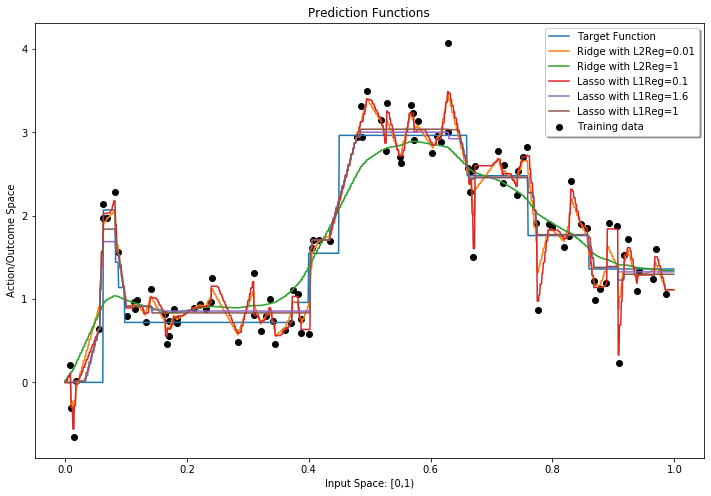

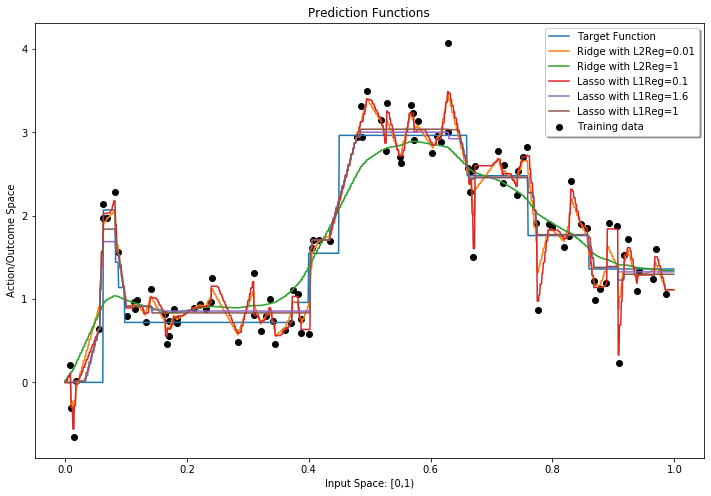

In [68]:
plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")

In [69]:
def compare_parameter_vectors(pred_fns):

	fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (20,20))
	num_ftrs = len(pred_fns[0]["coefs"])
	for i in range(len(pred_fns)):
		title = pred_fns[i]["name"]
		coef_vals = pred_fns[i]["coefs"]
		axs[i].bar(range(num_ftrs), coef_vals, color = "tab:purple")
		axs[i].set_xlabel('Feature Index')
		axs[i].set_ylabel('Parameter Value')
		axs[i].set_title(title)

	fig.subplots_adjust(hspace=0.4)
	return fig

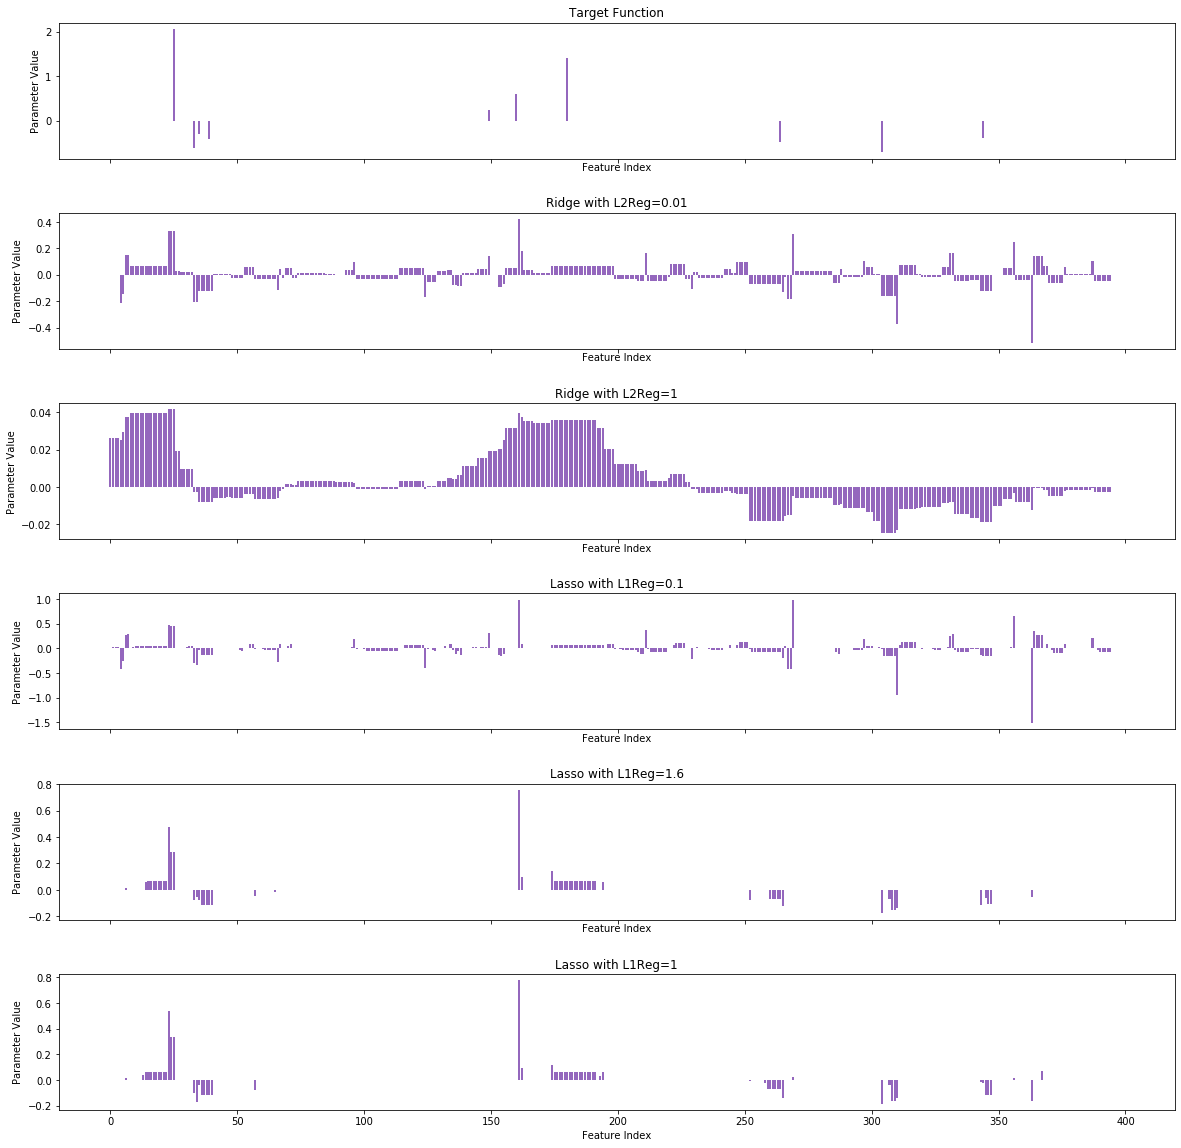

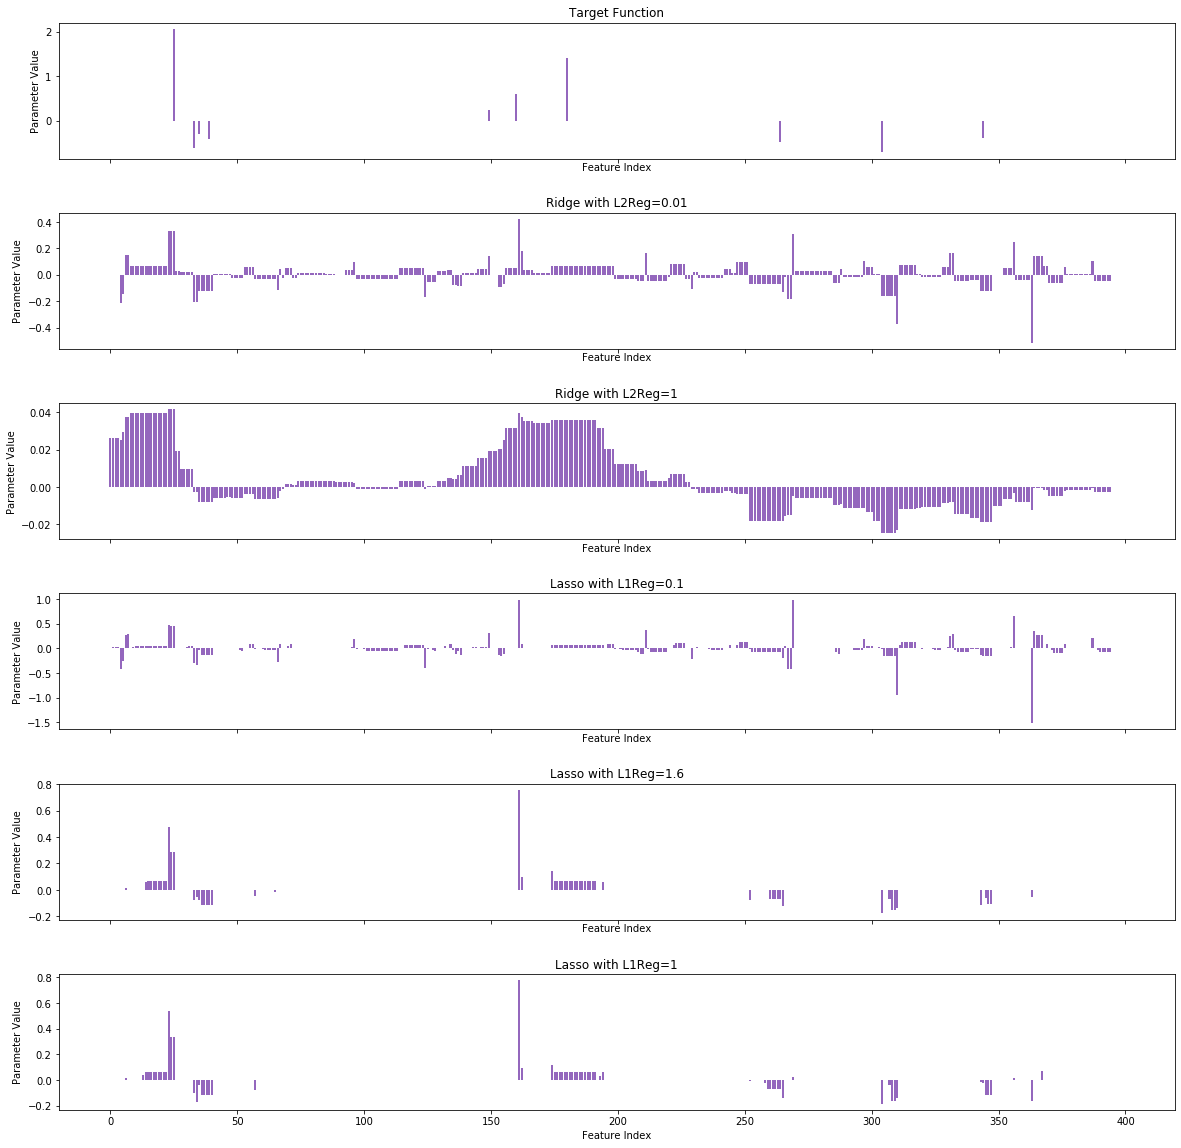

In [70]:
compare_parameter_vectors(pred_fns)

In [75]:
compute_sum_sqr_loss(X_val, y_val, pred_fns[4]['coefs'])


113.81019045036685

Ridge co-efficients are always non-zero.<br>
Therefore, penalty distribution amongst them is much denser than that of Lasso.<br>
Lasso has the property of feature selection and puts a zero weight in most features.<br>
This also affects the scale of the values that the coefficients can take.<br>
For example, in Lasso we observe that the coefficients are able to take larger values (> 0.7) <br>
however in Ridge the maximum value taken by the coefficients is around 0.4. <br> <br>

The best model has the following config:<br>
$\lambda = 1.6$ <br>
randomized = True <br>
ridge initialization = False <br> <br>
The validation loss for this model is = 113.81019045036685 <br>


In [ ]:
def get_lambda_max_no_bias(X, y):
    return 2 * np.max(np.abs(np.dot(y, X)))